# Testing the IR AGN Selection from WISE
##### Authors: S. Juneau, M. Mezcua, B. Canning


### 1) First let's import some stuff!

In [1]:
# Numpy
import numpy as np
# Plotting stuff and suppressing boring warnings
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')

# Get the GQP code
import sys
# Set the path where the py scripts are
sys.path.append("../py/")
import set_agn_masksDESI

# Import Astropy libraries - useful for many astronomy related function
from astropy.table import Table #, join, Column
from astropy.io import fits

settings = {
    'font.size':14,
    'axes.linewidth':2.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':2.0,
    'xtick.minor.width':1.,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':2.0,
    'ytick.minor.width':1.,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True,
    'axes.labelsize':16
}

plt.rcParams.update(**settings)

### 2) Now we are ready to open the catalog.

The internal GQP drive at NERSC is

        /global/cfs/cdirs/desi/science/gqp/

From there we can find the 'agncatalog' folder and follow the link on to 'catalog'

In [2]:
def return_catdir(location='nersc'):

    dl_path = '~/data/DESI/science/gqp/agncatalog/catalog/'
    nersc_path = '/global/cfs/cdirs/desi/science/gqp/agncatalog/catalog/'

    if location=='datalab':
        return(dl_path)
    else:
        return(nersc_path)  #default

In [3]:
## Set below if working at Data Lab (need to copy catalog over first) or at NERSC
#catdir = return_catdir(location='datalab') # Astro Data Lab
catdir = return_catdir() # NERSC

# Open the catalog
agn_hdul = fits.open(f'{catdir}agnqso_sum_v1.3.fits', format='fits')
agn_hdul.info()

Filename: /global/cfs/cdirs/desi/science/gqp/agncatalog/catalog/agnqso_sum_v1.3.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU    332   2254019R x 149C   [K, D, D, K, 6A, J, D, D, 4A, E, I, I, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, J, 7A, 6A, J, E, J, L, K, L, K, K, K, K, K, K, K, K, K, K, K, K, K, K, D, D, 1A, K, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, E, K, K]   


As we can see the data is stored in extension number 1.

In [4]:
# Load this into an astropy table
T = Table(agn_hdul[1].data)

Let's print the columns in this catalog.

In [5]:
# What are the columns?
T.columns

<TableColumns names=('TARGETID','Z','ZERR','ZWARN','SPECTYPE','COADD_FIBERSTATUS','TARGET_RA','TARGET_DEC','MORPHTYPE','EBV_1','MASKBITS','COADD_NUMEXP','COADD_EXPTIME','TSNR2_LYA','TSNR2_QSO','DELTA_CHI2_MGII','A_MGII','SIGMA_MGII','B_MGII','VAR_A_MGII','VAR_SIGMA_MGII','VAR_B_MGII','Z_RR','Z_QN','C_LYA','C_CIV','C_CIII','C_MgII','C_Hbeta','C_Halpha','Z_LYA','Z_CIV','Z_CIII','Z_MgII','Z_Hbeta','Z_Halpha','QSO_MASKBITS','SURVEY','PROGRAM','HEALPIX','TSNR2_LRG','SV_NSPEC','SV_PRIMARY','ZCAT_NSPEC','ZCAT_PRIMARY','NPIXELS','DESI_TARGET','BGS_TARGET','SCND_TARGET','CMX_TARGET','SV1_DESI_TARGET','SV1_BGS_TARGET','SV1_SCND_TARGET','SV2_DESI_TARGET','SV2_BGS_TARGET','SV2_SCND_TARGET','SV3_DESI_TARGET','SV3_BGS_TARGET','SV3_SCND_TARGET','QN_C_LINE_BEST','QN_C_LINE_SECOND_BEST','PHOTSYS','LS_ID','FIBERFLUX_G','FIBERFLUX_R','FIBERFLUX_Z','FIBERTOTFLUX_G','FIBERTOTFLUX_R','FIBERTOTFLUX_Z','FLUX_G','FLUX_R','FLUX_Z','FLUX_W1','FLUX_W2','FLUX_W3','FLUX_W4','FLUX_IVAR_G','FLUX_IVAR_R','FLUX_IVAR_Z'

In particular we acess information about the AGN and QSO diagnostics via the AGN_MASKBITS and AGN_TYPE columns. We can read the definitions for the bitmasks in the yaml file.

In [6]:
AGN_MASKBITS, AGN_TYPE = set_agn_masksDESI.get_qso_maskbits('../py/agnmask.yaml')

These are the bitmask which contain the infomation. The format of these bitmasks is:    

    - [name of the target bit,  bit value,  "description as a string"]
    
For example:

    - [NII_SY,           8, "NII BPT Seyfert"]
    
This means the name of the target bit is NII_SY, its bit value is 2$^{8}$ and its description is a Seyfert object according to the NII BPT.

So let's see what the bitmasks look like.

In [7]:
print(AGN_MASKBITS)

AGN_MASKBITS:
  - [AGN_ANY,          0, "any AGN classification is set"]
  - [RR,               1, "RR determines this to be a QSO from template fitting"]
  - [MGII,             2, "MgII afterburner detects broad line"]
  - [QN,               3, "Quasar Net reclassifies as a QSO"]
  - [QN_NEW_RR,        4, "Quasar Net prompts different RR redshift"]
  - [QN_BGS,           5, "Quasar Net reclassifies BGS target as a QSO"]
  - [QN_ELG,           6, "Quasar Net reclassifies ELG target as a QSO"]
  - [QN_VAR_WISE,      7, "Quasar Net reclassifies VAR_WISE_QSO target as a QSO"]
  - [BPT_ANY_SY,      10, "At least one BPT diagnostic indicates SEYFERT"]
  - [BPT_ANY_AGN,     11, "At least one BPT diagnostic indicates SEYFERT, LINER or COMPOSITE"]
  - [OPT_OTHER_AGN,   12, "Rest frame optical emission lines diagnostic not BPT (4000-10000 ang) indicate AGN"]
  - [UV,              13, "Rest frame UV emission lines indicate AGN"]
  - [WISE,            14, "Infrared (WISE) colours indicate AGN"]
 

In [8]:
print(AGN_TYPE)

AGN_TYPE:
  - [OPT_TYPE_UNKNOWN,  0, "Optical/UV AGN lacking Halpha, Hbeta, MgII and CIV line constraints"]
  - [OPT_TYPE1,        1, "Optical/UV Type 1 AGN (FWHM>=1200 km/s in Halpha, Hbeta, MgII and/or CIV line)"]
  - [OPT_TYPE2,        2, "Optical/UV Type 2 AGN (FWHM<1200 km/s in Halpha, Hbeta, MgII and/or CIV line)"]
  - [BPT_SY,           3, "Any BPT diagnostic indicates Seyfert"]
  - [BPT_LINER,        4, "Any BPT diagnostic indicates LINER"]
  - [NII_BPT_AV,       5, "NII BPT diagnostic is avalible (update_AGNTYPE_NIIBPT)"]
  - [NII_SF,           6, "NII BPT Star-forming (update_AGNTYPE_NIIBPT)"]
  - [NII_COMP,         7, "NII BPT Composite (update_AGNTYPE_NIIBPT)"]
  - [NII_SY,           8, "NII BPT Seyfert (update_AGNTYPE_NIIBPT)"]
  - [NII_LINER,        9, "NII BPT LINER (update_AGNTYPE_NIIBPT)"]
  - [NII_QUIES,       10, "NII BPT Quiescent, Lines detected with (S/N) < 3 (update_AGNTYPE_NIIBPT)"]
  - [SII_BPT_AV,      11, "SII BPT diagnostic is available (update_AGNTYPE_SIIBP

### 3) IR diagnostic diagram: WISE Color-Color

#### NOTE: The BITMASK is currently wrong in the catalog (v1.0 - v1.3) so we will re-do the classification manually below

In [9]:
## Check bitmask for WISE_AGN (Question: why use 'AGN_TYPE' rather than 'AGN_MASKBITS'?)
is_wise = (T['AGN_TYPE'] & AGN_TYPE.WISE_AGN != 0)

In [10]:
## S/N in WISE bands
snr_w1 = T['FLUX_W1']*np.sqrt(T['FLUX_IVAR_W1'])
snr_w2 = T['FLUX_W2']*np.sqrt(T['FLUX_IVAR_W2'])
snr_w3 = T['FLUX_W3']*np.sqrt(T['FLUX_IVAR_W3'])

thres = 3
w1w2_only = (snr_w1>thres)&(snr_w2>thres)&(snr_w3<=thres)
w1w2w3 = (snr_w1>thres)&(snr_w2>thres)&(snr_w3>thres)

## WISE colors in AB magnitudes (W1-W2 and W2-W3)
w2 = -2.5*np.log10(T['FLUX_W2']) + 22.5
w1w2 = -2.5*np.log10(T['FLUX_W1']/T['FLUX_W2'])
w2w3 = -2.5*np.log10(T['FLUX_W2']/T['FLUX_W3'])

Text(0, 0.5, 'W1-W2 [AB]')

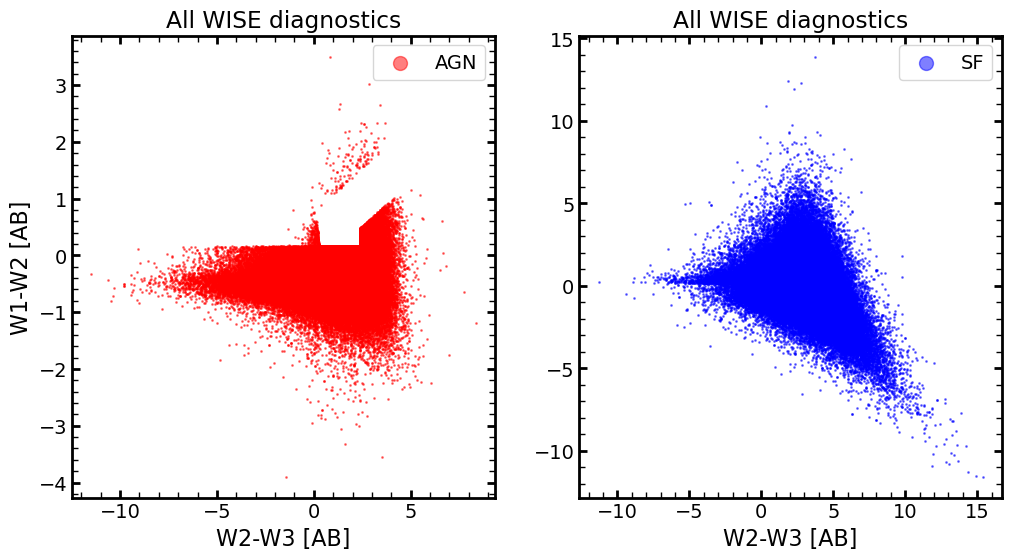

In [11]:
## Figure with separate panel for AGN (left) and SF (right)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
ax1.scatter(w2w3[is_wise], w1w2[is_wise], color='r', s=1, alpha=0.5, label='AGN')
ax2.scatter(w2w3[~is_wise], w1w2[~is_wise], color='b', s=1, alpha=0.5, label='SF')

for ax in [ax1, ax2]:
    ax.set_xlabel('W2-W3 [AB]')
    ax.set_title('All WISE diagnostics')
    ax.legend(markerscale=10)
ax1.set_ylabel('W1-W2 [AB]')

### Import the WISE color classification code and re-classify

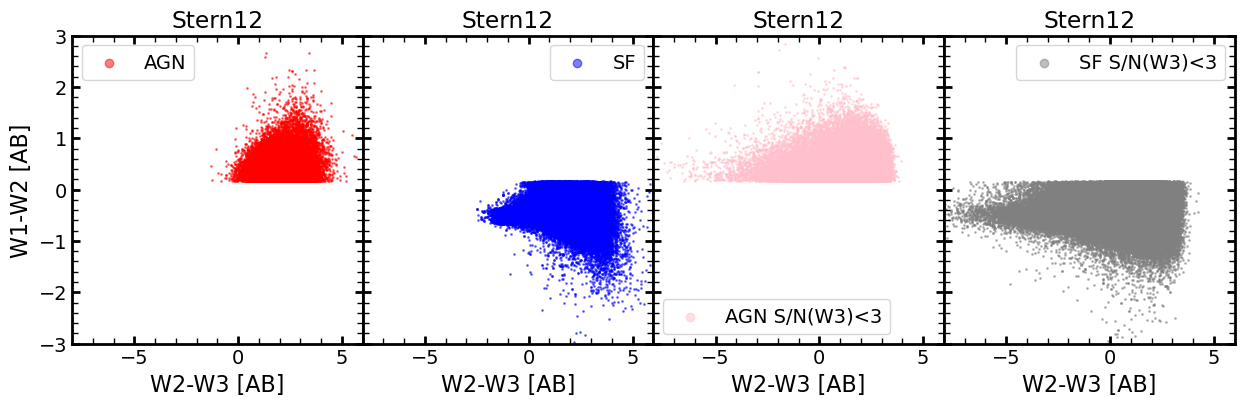

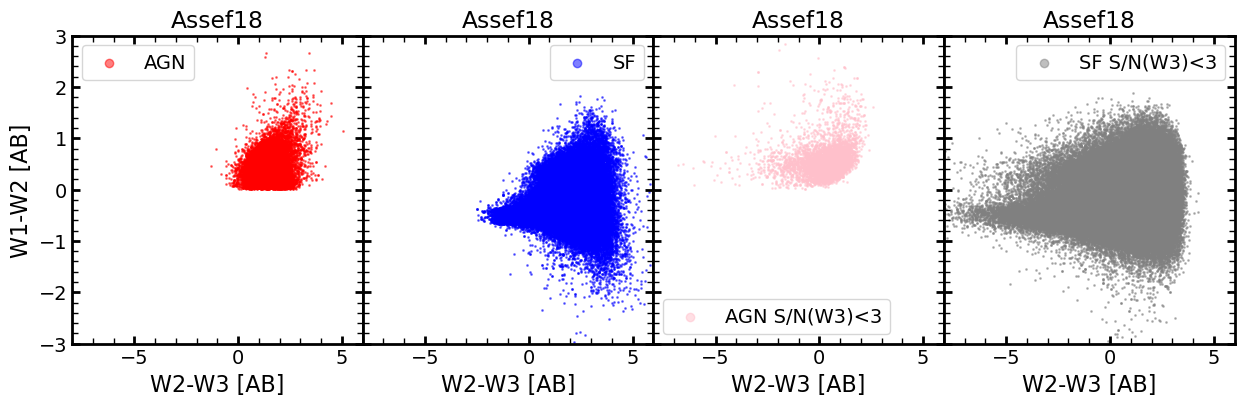

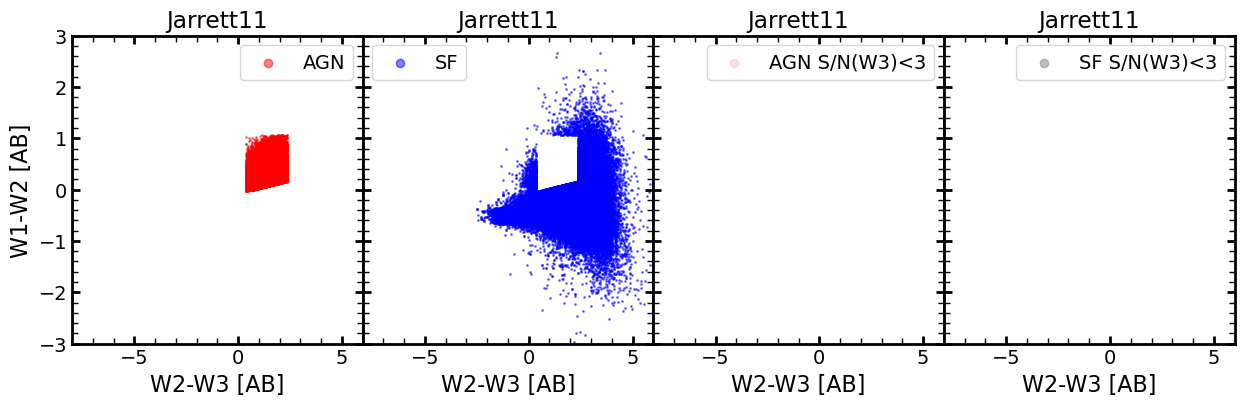

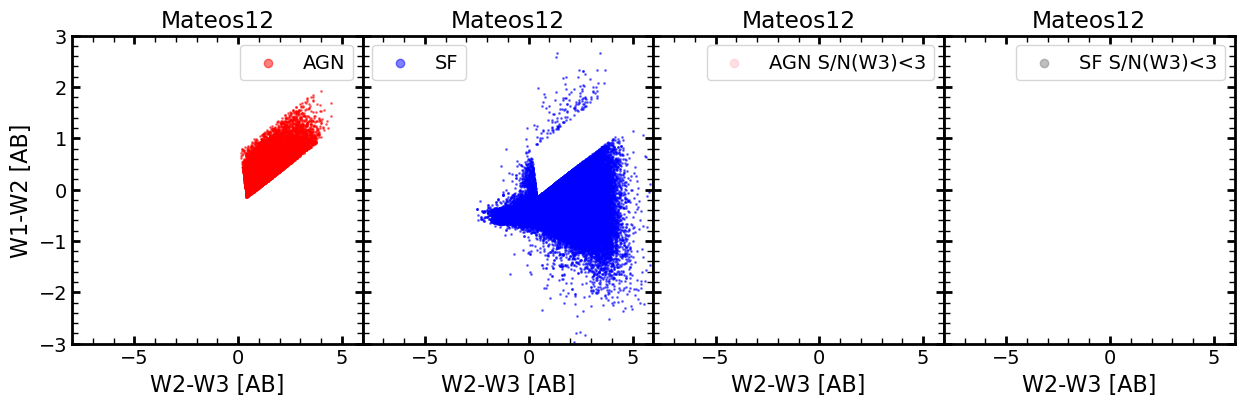

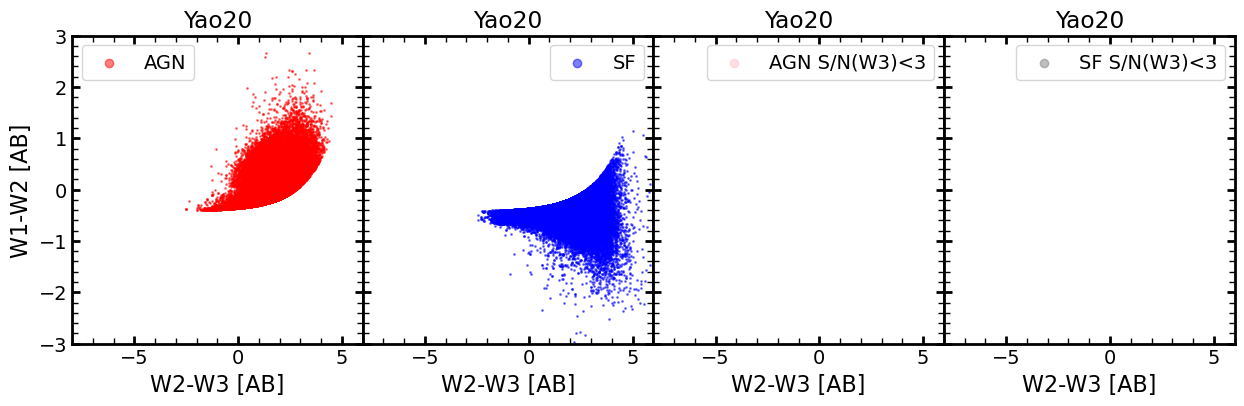

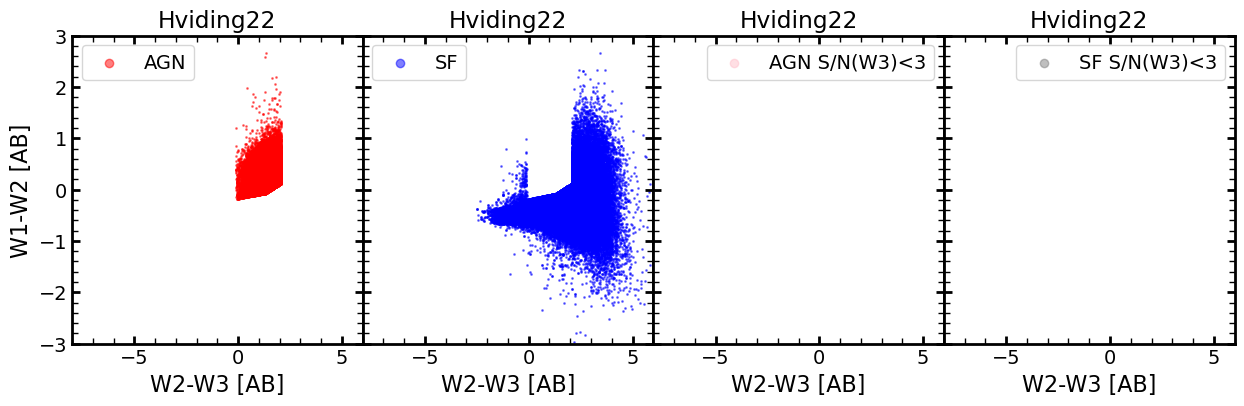

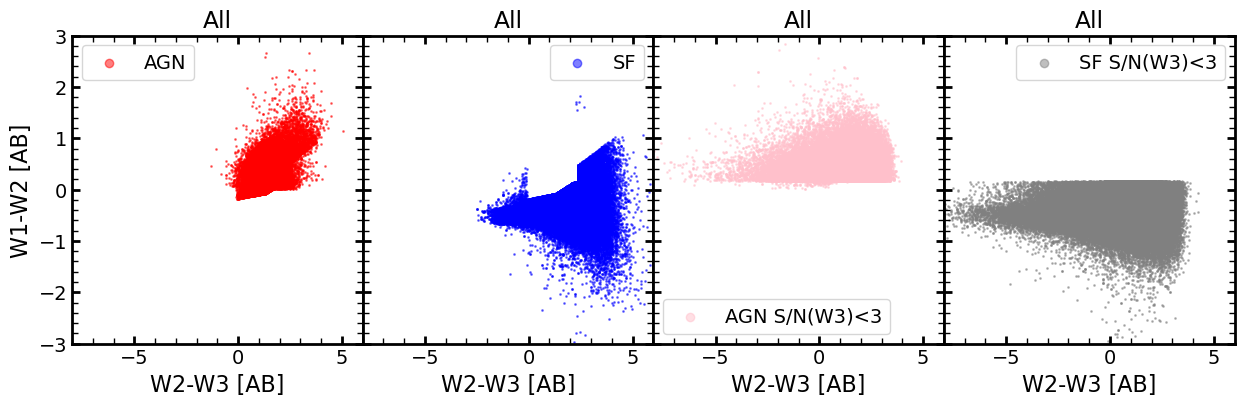

In [12]:
from AGNdiagnosticsFunctionsDESI import WISE_colors

#diags = ['Stern12', 'All']
diags = ['Stern12', 'Assef18', 'Jarrett11', 'Mateos12', 'Yao20', 'Hviding22', 'All']

for diag in diags:
    
    is_avail, agn_ir, sf_ir = WISE_colors(T, snr=3., mask=None, diag=diag)
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15,4), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.)

    ax1.scatter(w2w3[agn_ir&w1w2w3], w1w2[agn_ir&w1w2w3], color='r', s=1, alpha=0.5, label='AGN')
    ax2.scatter(w2w3[sf_ir&w1w2w3], w1w2[sf_ir&w1w2w3], color='b', s=1, alpha=0.5, label='SF')
    ax3.scatter(w2w3[agn_ir&w1w2_only], w1w2[agn_ir&w1w2_only], color='pink', s=1, alpha=0.5, label='AGN S/N(W3)<3')
    ax4.scatter(w2w3[sf_ir&w1w2_only], w1w2[sf_ir&w1w2_only], color='grey', s=1, alpha=0.5, label='SF S/N(W3)<3')
#    ax2.scatter(w2w3[sf_ir], w1w2[sf_ir], color='b', s=1, alpha=0.5, label='SF')

    for ax in [ax1, ax2, ax3, ax4]:
        ax.set_xlabel('W2-W3 [AB]')
        ax.set_title(diag)
        ax.legend(markerscale=6)
        ax.set_xlim(-8,6)
        ax.set_ylim(-3,3)
    ax1.set_ylabel('W1-W2 [AB]')

In [21]:
def assef18_line(reliability=90):
    
    ## 90% reliability
    alpha_90 = 0.65
    beta_90 = 0.153
    gamma_90 = 13.86        
                    
    ## 75% reliability
    alpha_75 = 0.486
    beta_75 = 0.092
    gamma_75 = 13.07 
     
    ## Choose here (default 90%):
    if reliability==90:
        alpha = alpha_90
        beta = beta_90
        gamma = gamma_90
    if reliability==75:
        alpha = alpha_75
        beta = beta_75
        gamma = gamma_75
     
    ## Dummy values for W2 in Vega mags
    xx = np.arange(10, 20, 0.1)
    
    # Offsets from Vega to AB magnitudes (Jarrett+2011) 
    W1_vega2ab = 2.699
    W2_vega2ab = 3.339
    W3_vega2ab = 5.174

    ## Assef+2018 diagnostic
    is_bright_a18 = xx<=gamma
    yy = alpha* np.exp(beta*(xx-gamma)**2)
    yy[is_bright_a18] = alpha
    
    # Return in AB mags fot DESI
    return(xx+W2_vega2ab, yy+(W1_vega2ab-W2_vega2ab))

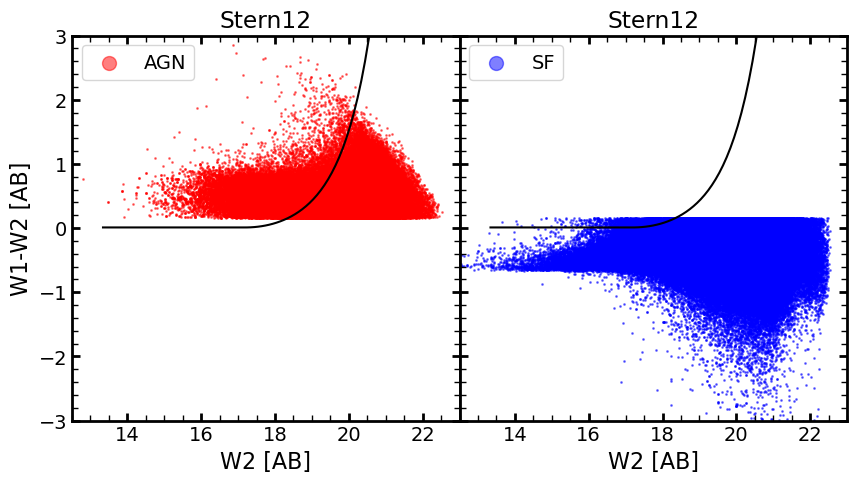

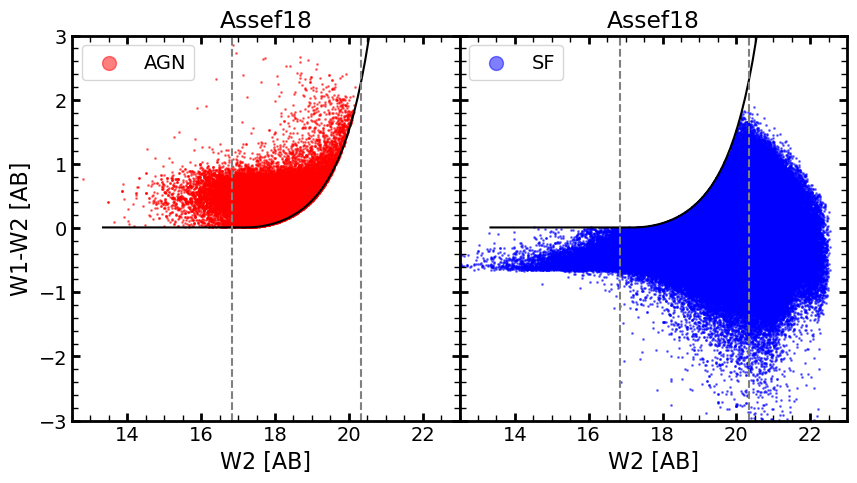

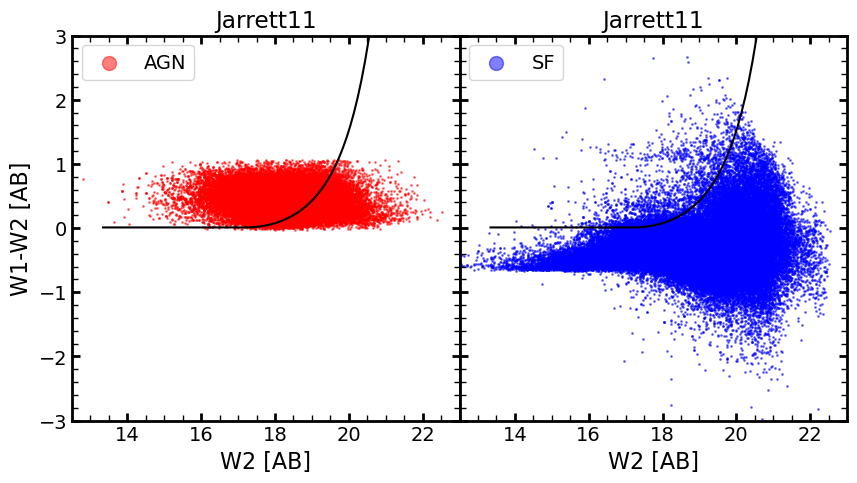

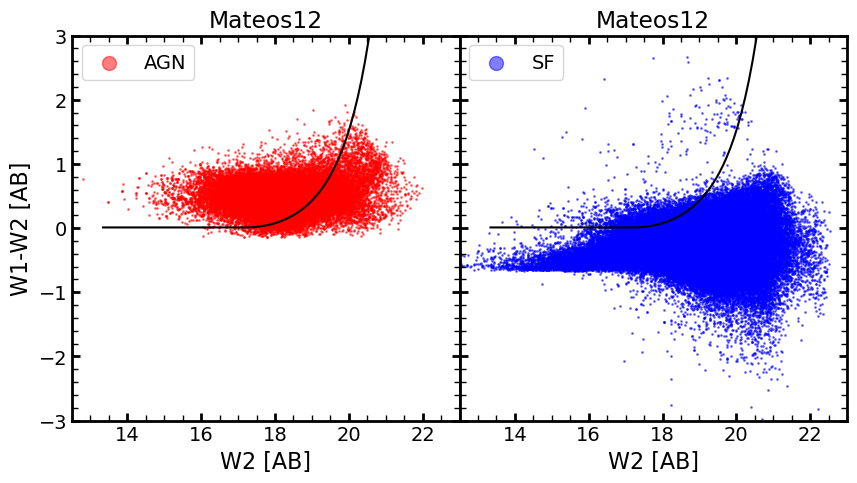

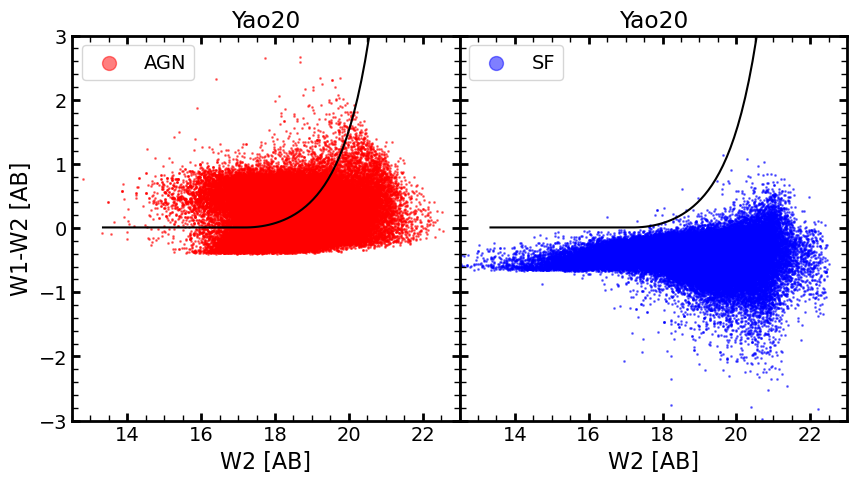

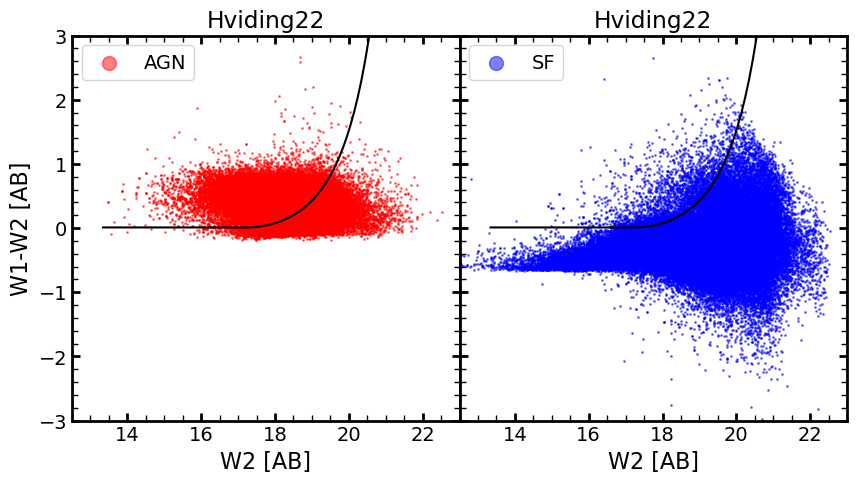

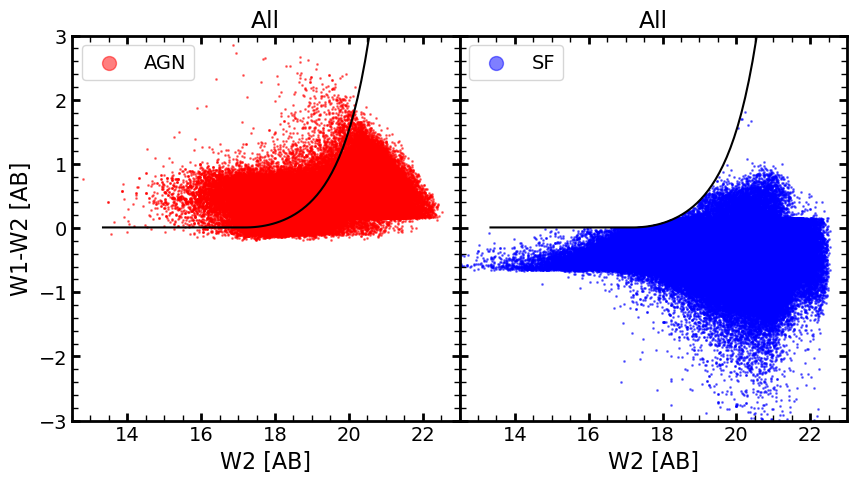

In [22]:
diags = ['Stern12', 'Assef18', 'Jarrett11', 'Mateos12', 'Yao20', 'Hviding22', 'All']

## offset from Vega to AB mag
W2_vega2ab = 3.339

xx_a18, yy_a18 = assef18_line()

for diag in diags:
    
    W1W2_avail, agn_ir, sf_ir = WISE_colors(T, snr=3., mask=None, diag=diag)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.)

    ax1.scatter(w2[agn_ir], w1w2[agn_ir], color='r', s=1, alpha=0.5, label='AGN')
    ax2.scatter(w2[sf_ir], w1w2[sf_ir], color='b', s=1, alpha=0.5, label='SF')

    for ax in [ax1, ax2]:
        ax.set_xlabel('W2 [AB]')
        ax.set_title(diag)
        ax.legend(markerscale=10)
        ax.set_xlim(12.5, 23)
        ax.set_ylim(-3,3)
        
        ax.plot(xx_a18, yy_a18, color='k', label='Assef+18')
        
        if diag=='Assef18':
            # Approx range used in Assef+18 work
            ax.axvline(13.5+W2_vega2ab, ls='--', color='grey')
            ax.axvline(17+W2_vega2ab, ls='--', color='grey')
    ax1.set_ylabel('W1-W2 [AB]')
    
